# Content

In this notebook we test the ability of our distance to distinguish different temporal shufflings. To speed up the simulation, the embeddings are computed separately and loaded from the folder `Data/Embeddings/Shuffling` and then we run tests on both the global and local distances. The notebook to produce the embedding is contained in the `Data` folder and is called `Get embeddings`

In [1]:
import matplotlib.pyplot as plt
from os import listdir
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from joblib import Parallel, delayed

import sys
sys.path += ['dir_to_Package/Package']

from MatrixDistance import *
from Utilities import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
def f(x):
    '''Convenient function to load data'''
    if len(x) > 1:
        y = x[0]
        for i in range(1, len(x)):
            y = y + '_' + x[i]
            
    else:
        y = x[0]

    return y


def GetDistanceMatrices(gname, n_graphs, all_gtypes):
    
    # load the embeddings
    Xlist = [[] for i in all_gtypes]

    for j, gtype in enumerate(all_gtypes):
        for i in range(n_graphs):
            x = np.loadtxt('Data/Embeddings/Shuffling/' + gname + '-' + gtype + '/EL' + str(i+1) + '.dat')
            Xlist[j].append(x)

    # get the distance matrices for all shuffling pairs
    for i in range(len(Xlist)):
        for j in range(i+1, len(Xlist)):
            
            M = np.zeros((2*n_graphs, 2*n_graphs))
            M_glob = np.zeros((2*n_graphs, 2*n_graphs))
            allX = np.concatenate([Xlist[i], Xlist[j]])

            # precompute the embedding frobenius norms and eigenvalues
            norms, eigenvals = [], []

            for X in allX:
                Mxx = X.T@X
                norms.append(np.linalg.norm(Mxx)**2)
                eigenvals.append(np.sort(np.linalg.eigvalsh(Mxx)))

            for x, X in enumerate(allX):
                for y, Y in enumerate(allX):
                    if y > x:
                        M[x,y] = np.sqrt(norms[x] + norms[y] - 2*np.linalg.norm(X.T@Y)**2)
                        M_glob[x,y] = np.linalg.norm(eigenvals[x] - eigenvals[y])
                        
            # symmetrize the distance matrix
            M = M + M.T
            M_glob = M_glob + M_glob.T

            # save
            np.savetxt('Data/Results/distance/' + gname + '_' + all_gtypes[i] + '_' + all_gtypes[j] + '_M.dat', M)
            np.savetxt('Data/Results/distance/' + gname + '_' + all_gtypes[i] + '_' + all_gtypes[j] + '_M_glob.dat', M_glob)

    return

    
def GetNMI(gname, all_gtypes, n_graphs, ℓ):
    
    
    NMI_mat = np.zeros((len(all_gtypes), len(all_gtypes)))
    NMI_glob = np.zeros((len(all_gtypes), len(all_gtypes)))


    for x in range(len(all_gtypes)):
        t1 = all_gtypes[x]
        for y in range(x+1, len(all_gtypes)):
            t2 = all_gtypes[y]

            M = np.loadtxt('Data/Results/distance/' + gname + '_' + t1 + '_' + t2 + '_M.dat')
            M_glob = np.loadtxt('Data/Results/distance/' + gname + '_' + t1 + '_' + t2 + '_M_glob.dat')
            

            NMI_mat[x,y] = NMI(ℓ, ClusterNMF(M, 2))
            NMI_glob[x,y] = NMI(ℓ, ClusterNMF(M_glob, 2))

    # save
    df = pd.DataFrame(NMI_mat, columns = all_gtypes)
    df.rename(index = dict(zip(np.arange(len(all_gtypes)), all_gtypes)), inplace = True)
    df.to_csv('Data/Results/NMI/' + gname + 'NMI_matched.csv')

    df = pd.DataFrame(NMI_glob, columns = all_gtypes)
    df.rename(index = dict(zip(np.arange(len(all_gtypes)), all_gtypes)), inplace = True)
    df.to_csv('Data/Results/NMI/' + gname + 'NMI_unmatched.csv')

    return 

In [5]:
n_graphs = 250

# ground truth assignment 
n = 2*n_graphs
ℓ = np.ones(n)
ℓ[:int(n/2)] = 0

all_gtypes = listdir('Data/Embeddings/Shuffling')

# graphs names
all_gnames = np.unique([x.split('-')[0] for x in all_gtypes])

# shuffling types
all_gtypes = np.unique([f(x.split('-')[1:]) for x in all_gtypes])

In [12]:
# get the distance matrices
Pl = Parallel(n_jobs = 8, verbose = 8)    
_ = Pl(delayed(GetDistanceMatrices)(gname, n_graphs, all_gtypes) for gname in all_gnames)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:  1.4min remaining:  5.0min
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:  1.5min remaining:  1.8min
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:  1.7min remaining:   51.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:  2.5min finished


In [16]:
# get NMI matrices
Pl = Parallel(n_jobs = 8, verbose = 8)    
_ = Pl(delayed(GetNMI)(gname, all_gtypes, n_graphs, ℓ) for gname in all_gnames)

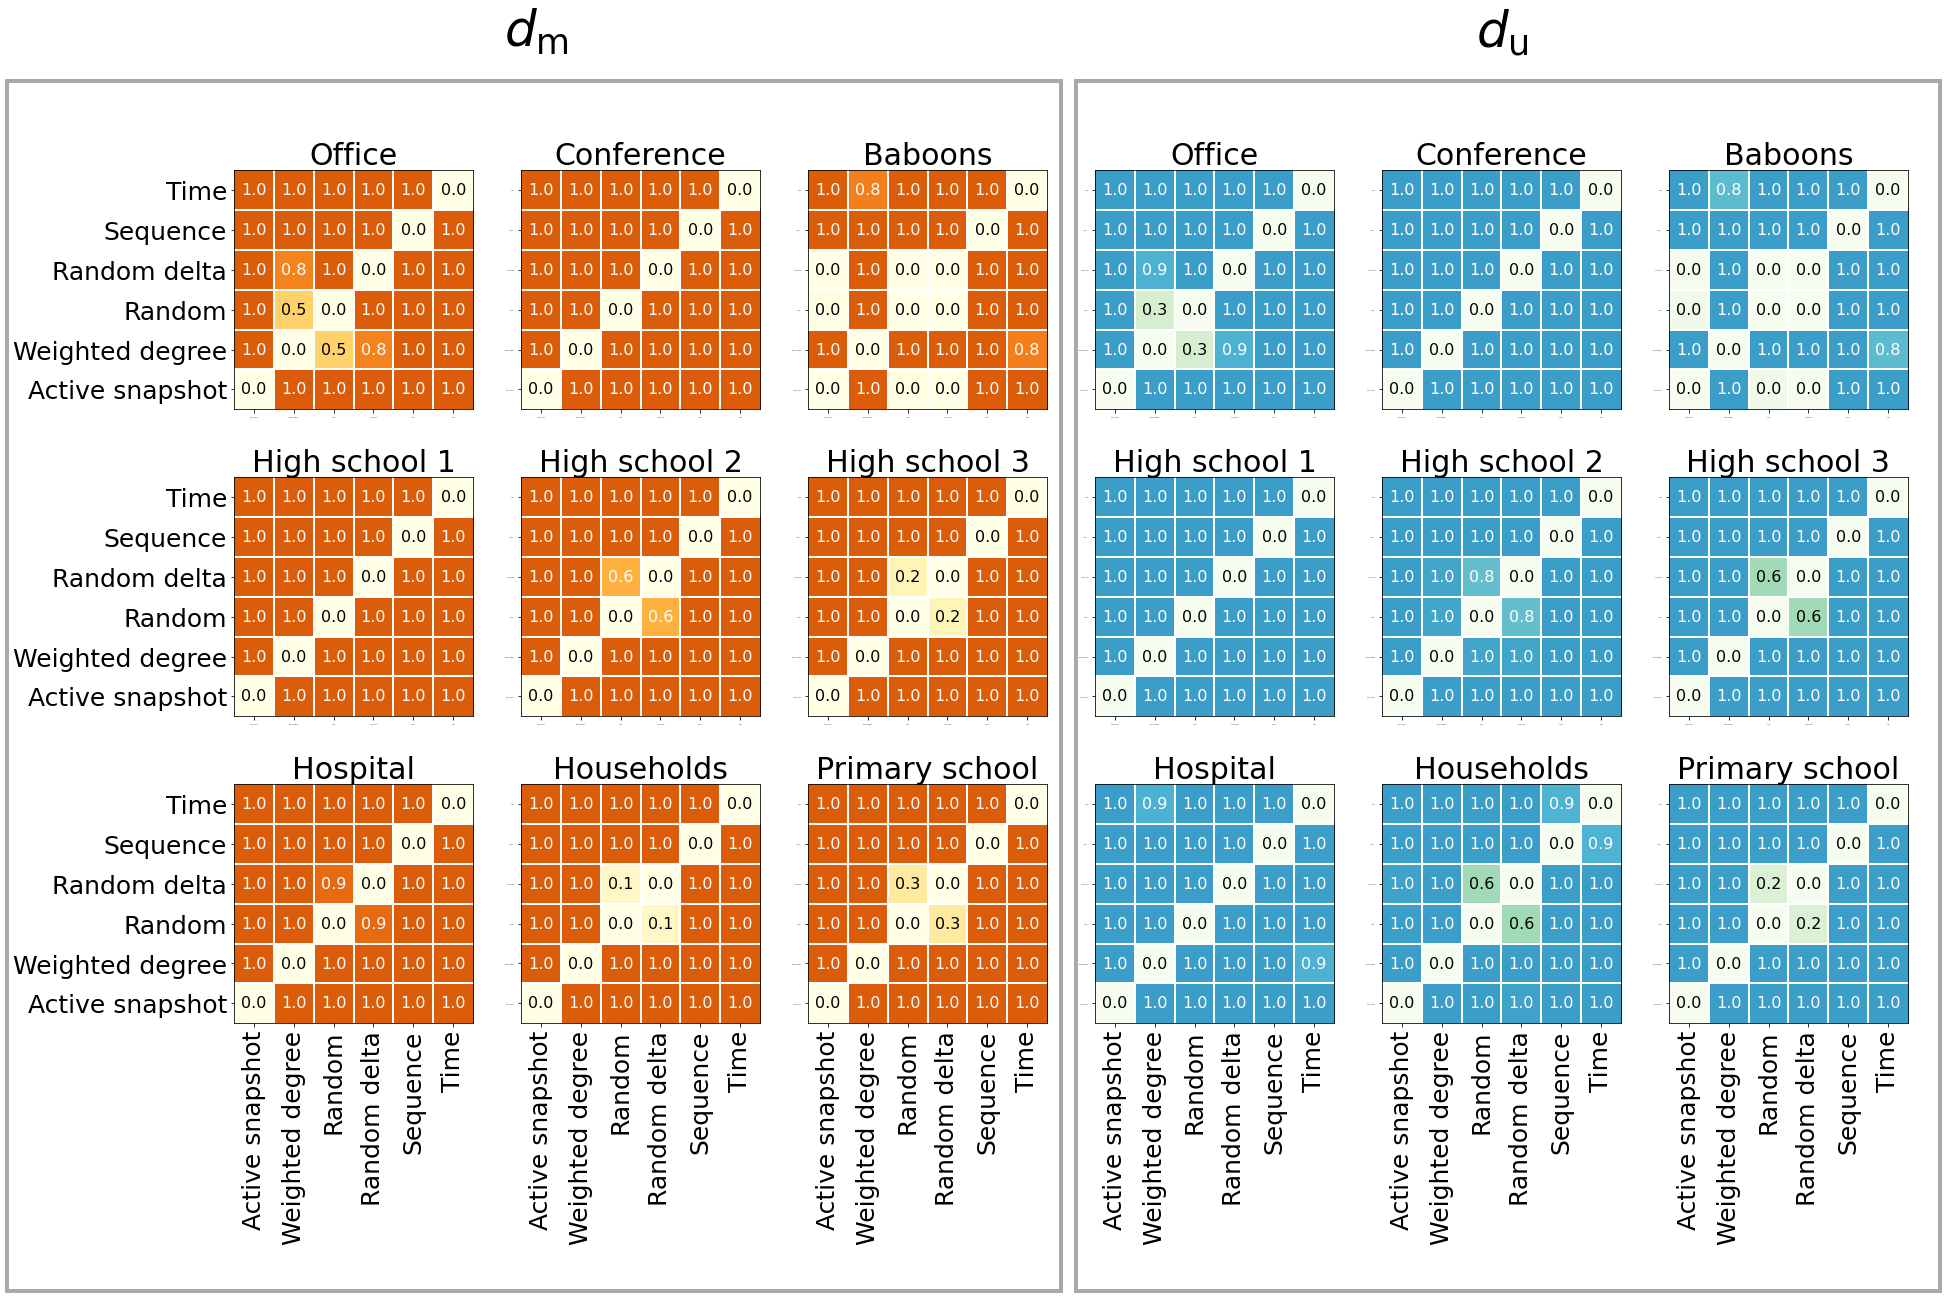

In [28]:
# plot
cmaps = ['YlOrBr', 'GnBu']
fs = 25
names = [" ".join(g.capitalize().split('_')) for g in all_gtypes]
names[names.index('Activity driven')] = 'Weighted degree'

name_mapper = dict(zip(all_gnames, ['Office', 'Conference', 'Baboons', 'High school 1', 'High school 2', 'High school 3',
'Hospital', 'Households', 'Primary school']))

fig, ax = plt.subplots(3, 6, figsize = (30, 16))

ROOT = 'Data/Results/NMI/' 

for i, name in enumerate(all_gnames):  
    x = int(i/3)
            
    for t, typeof in enumerate(['matched', 'unmatched']):

        y = i - 3*x + 3*t


        if y == 0:
            ax[x,y].set_yticks(np.arange(len(all_gtypes)))
            ax[x,y].set_yticklabels(names, fontsize = fs)
        else:
            ax[x,y].set_yticks(np.arange(len(all_gtypes)))
            ax[x,y].set_yticklabels(names, fontsize = 0)


        M = pd.read_csv(ROOT + name + 'NMI_' + typeof + '.csv').set_index('Unnamed: 0').values
        ax[x,y].imshow(M + M.T, cmap = cmaps[t], vmin = 0, vmax = 1.45, origin = 'lower')

        for r in range(np.shape(M)[0]-1):
            ax[x,y].axvline(r+0.5, color = 'white', linewidth = 2)
            ax[x,y].plot(np.arange(np.shape(M)[0]+1)-0.5, r*np.ones(np.shape(M)[0]+1) + 0.5, color = 'white', linewidth = 2)


        for (b,a),label in np.ndenumerate(M + M.T):
            if label < 0.6:
                ax[x,y].text(a,b,np.round(label,1), ha = 'center',va ='center', fontsize = 16, color = 'k')
            else:
                ax[x,y].text(a,b,np.round(label,1), ha = 'center',va ='center', fontsize = 16, color = 'white')

        ax[x,y].set_title(name_mapper[name], fontsize = 30)

        if x != 2:
            ax[x,y].set_xticks(np.arange(len(all_gtypes)))
            ax[x,y].set_xticklabels(names, fontsize = 0)    
        else:
            ax[x,y].set_xticks(np.arange(len(all_gtypes)))
            ax[x,y].set_xticklabels(names, rotation = 90, fontsize = fs)
    
rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.02, -0.1), 0.488, 1.05, fill = False, color = "darkgrey", lw = 4, 
    zorder=1000, transform=fig.transFigure, figure=fig)

rect2 = plt.Rectangle(
    # (lower-left corner), width, height
    (0.515, -0.1), 0.4, 1.05, fill = False, color = "darkgrey", lw = 4, 
    zorder = 1000, transform = fig.transFigure, figure = fig)

fig.patches.extend([rect, rect2])

fig.text(0.25,0.98, r'$d_{\rm m}$', fontsize = 50)
fig.text(0.7,0.98, r'$d_{\rm u}$', fontsize = 50)
    
plt.show();